In [ ]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61kB 3.9MB/s 
     |████████████████████████████████| 1.3MB 12.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.11-cp37-cp37m-linux_x86_64.whl size=2725456 sha256=bccf2d0333bbd86361a3f71fe341c152f87f6b01d5df3dd8fe5e4c74b45ac1a2
  Stored in directory: /root/.cache/pip/wheels/df/d4/eb/c74e09a39bc4ac09b3a8d2a48c1c6009f391056d8c87bf68aa
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
##imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
from pypfopt import plotting
from matplotlib.ticker import FuncFormatter
from pypfopt import discrete_allocation
from scipy.stats import norm

In [ ]:
 ##Scraping data for Adj close price
tickers = ['INDIGO.NS', 'JETAIRWAYS.NS', 'ICICIBANK.NS', 'SBIN.NS', 'TATACHEM.NS', 'TATACOMM.NS']
thelen = len(tickers)
price_data = []

#Getting the open/close prices
for ticker in range(thelen):
  prices = web.DataReader(tickers[ticker], start='2019-01-01', end='2019-12-31', data_source='yahoo')
  price_data.append(prices.assign(ticker=ticker)[['Adj Close']])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.head()


,INDIGO.NS,JETAIRWAYS.NS,ICICIBANK.NS,SBIN.NS,TATACHEM.NS,TATACOMM.NS
Date,,,,,,
2019-01-01,1161.959595,280.799988,361.981659,299.600006,667.345398,514.936157
2019-01-02,1157.373901,263.549988,362.827515,293.899994,663.134888,514.048828
2019-01-03,1152.937866,247.199997,361.484100,291.100006,657.079285,528.493652
2019-01-04,1139.629517,245.199997,363.424622,297.649994,660.864075,524.007385
2019-01-07,1110.271484,246.199997,365.912445,296.299988,662.236084,521.443726


In [ ]:
##Check for Nan

In [ ]:
nullin_df = pd.DataFrame(df_stocks, columns=tickers)
print(nullin_df.isnull().sum())
##No Nan values (Conclusion)

INDIGO.NS        0
JETAIRWAYS.NS    0
ICICIBANK.NS     0
SBIN.NS          0
TATACHEM.NS      0
TATACOMM.NS      0
dtype: int64


In [ ]:
 #Calculate returns and covariance matrix
returns = df_stocks.pct_change()
cov_matrix_annual = returns.cov() * 242


In [ ]:
##Calculate variance and returns for 1000 weights and store values in list
portfolioSimpleAnnualReturn_list = []
port_volatility_list = []
val = [-1, 1]
for i in range(1000):
  weights = np.random.rand(6,1)
  for w in weights:
    w *= val[int(2*np.random.rand())]
  weights /= weights.sum()
  weights = weights.reshape(6)
  port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
  port_volatility = np.sqrt(port_variance)
  port_volatility_list.append(port_volatility)
  portfolioSimpleAnnualReturn = sum(returns.mean()*weights) * 242
  portfolioSimpleAnnualReturn_list.append(portfolioSimpleAnnualReturn)


Text(0.5, 1.0, 'Returns vs Volatility')

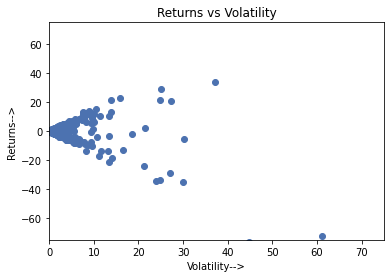

In [ ]:
 #Plot the graph
fig, ax = plt.subplots()
ax.scatter(port_volatility_list, portfolioSimpleAnnualReturn_list)
ax.set(xlim=(0, 75), ylim=(-75, 75))
ax.set(xlabel='Volatility-->', ylabel='Returns-->')
ax.set_title('Returns vs Volatility')

In [ ]:
 #Create Dataframe to calculate Sharpe Ratio
df = pd.DataFrame()
df["Portfolio Returns"] = portfolioSimpleAnnualReturn_list
df["Portfolio Volatility"] = port_volatility_list


In [ ]:
#Calculate sharpe ratio column
df["Sharpe Ratio"] = (df["Portfolio Returns"] - 0.04)/(df["Portfolio Volatility"])

In [ ]:
#Find index of max sharpe ratio
max_id = df['Sharpe Ratio'].idxmax(axis=1)
max_id

930

Text(0.5, 1.0, 'Returns vs Volatility')

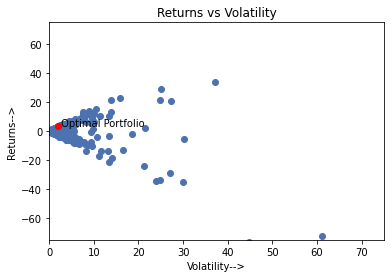

In [ ]:
#Plot the graph (With location of optimal portfolio in red)
fig, ax = plt.subplots()
ax.scatter(port_volatility_list, portfolioSimpleAnnualReturn_list)
ax.scatter(port_volatility_list[max_id], portfolioSimpleAnnualReturn_list[max_id], color='r')
ax.set(xlim=(0, 75), ylim=(-75, 75))
ax.annotate( " Optimal Portfolio",(port_volatility_list[max_id], portfolioSimpleAnnualReturn_list[max_id]) )
ax.set(xlabel='Volatility-->', ylabel='Returns-->')
ax.set_title('Returns vs Volatility')


In [ ]:
#Get portfolio with max shape ratio
ms = df.iloc[max_id]
ms_vol = df["Portfolio Volatility"].iloc[max_id]
ms_ret = df["Portfolio Returns"].iloc[max_id]

In [ ]:
ms


Portfolio Returns       3.511776
Portfolio Volatility    1.974924
Sharpe Ratio            1.757929
Name: 930, dtype: float64

In [ ]:
# df
num_days = 21
simulation_values = []
val = [-1, 1]
for i in range(5000):
  simulation_values.append(np.exp((0.4-0.5*ms_vol**2)*num_days/242 + ms_vol*np.sqrt(num_days/242)*norm.cdf(val[int(2*np.random.rand())]*np.random.rand())))

In [ ]:
#Checking number of sumulation values when the is loss
new_lis = []
new_lis = [val < 1 for val in simulation_values]
np.sum(new_lis)

680

In [ ]:
 #Convert values to array
simulation_values = np.array(simulation_values)

In [ ]:
#Find 5 and 1 percentile values
VAR_95 = np.percentile(simulation_values, 5)
VAR_99 = np.percentile(simulation_values, 1)

#Find VAR_95 and VAR_99
VAR_95 = (1 - VAR_95)*100
VAR_99 = (1 - VAR_99)*100

#Round the values
VAR_95 = round(VAR_95)
VAR_99 = round(VAR_99)

#Print the values
print(f"Value of VAR(95) = {VAR_95}%")
print(f"Value of VAR(99) = {VAR_99}%")


Value of VAR(95) = 3%
Value of VAR(99) = 4%


In [ ]:
# ##Calculate variance and returns for 1000 weights and store values in list
# portfolioSimpleAnnualReturn_list = []
# port_volatility_list = []
# for i in range(1000):
# weights = np.random.rand(6,1)
# weights /= weights.sum()
# weights = weights.reshape(6)
# port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
# port_volatility = np.sqrt(port_variance)
# port_volatility_list.append(port_volatility)
# portfolioSimpleAnnualReturn = sum(returns.mean()*weights) * 242
# portfolioSimpleAnnualReturn_list.append(portfolioSimpleAnnualReturn)
# #Plot the graph
# fig, ax = plt.subplots()
# ax.scatter(port_volatility_list, portfolioSimpleAnnualReturn_list)
# ax.set(xlabel='Volatility-->', ylabel='Returns-->')
# ax.set_title('Returns vs Volatility')